In [7]:
# possibly required libraries
import numpy as np
import matplotlib.pyplot as plt
import time as time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import ToTensor,Lambda
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [8]:
# load data
import os
data_dir = 'imagesoasis\Data'# change to data path
# labels = os.listdir(data_dir)
labels = ['Mild Dementia',
 'Very mild Dementia',
 'Moderate Dementia',
 'Non Demented']

transforms_list = transforms.Compose([transforms.Grayscale(),
                                      transforms.ToTensor()
                                      ])
dataset = ImageFolder(data_dir, transforms_list, target_transform=Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))




# Sthe random seed for reproducible datasets
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
# Split into training and testing set in the ratio of 0.7: 0.3
train_size = 0.7
test_size = 0.3

train_set, test_set = random_split(dataset, [train_size, test_size])

In [10]:
# Split datasets into batches with batch size = 32
batch_size = 32
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, num_workers=0, pin_memory=True)

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
      
    self.MaxPool = nn.MaxPool2d(2)
    # activations:
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

    # add flatten
    self.flatten = nn.Flatten()

    # linear layers
    self.fc1 = nn.Linear(117120,4)
    # add conv layers
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.conv2 = nn.Conv2d(8, 16, 3)
    self.bn1 = nn.BatchNorm2d(8)
    self.bn2 = nn.BatchNorm2d(16)
  def forward(self, x):
    # print('input shape: {}'.format(x.shape))
    x = self.conv1(x)
    x = self.bn1(x)
    # print('after conv shape: {}'.format(x.shape))
    x = self.MaxPool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.MaxPool(x)
    x = self.flatten(x)
    #print('after flatten shape: {}'.format(x.shape))
    x = self.fc1(x)
    # print('after fc1 shape: {}'.format(x.shape))
    # print('output shape: {}'.format(x.shape))
    return x
def evaluate(model, test_loader, device):
    correct = 0
    total = 0

    y_pred = []
    y_true = []


    with torch.no_grad():
        for images, labels in test_loader:
            bs = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(axis = 1)).sum().item()

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.argmax(axis = 1).tolist())
        return correct / total, y_pred, y_true

In [12]:
# initialize empty model and optimizer,loss_fn used for training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# load previously trained model:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['num_epochs']
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print('previously trained epoch number: {}'.format(epoch))
print('previously last batch trained loss: {}'.format(loss))

previously trained epoch number: 4
previously last batch trained loss: 0.007844455540180206


In [13]:
# report training and testing accuray:
# Evaluation function
device = "cuda" if torch.cuda.is_available() else "cpu"
def evaluate(model, test_loader, device):
  correct = 0
  total = 0

  y_pred = []
  y_true = []

  with torch.no_grad():
    for images, labels in test_loader:
      bs = images.shape[0]
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels.argmax(axis = 1)).sum().item()

      y_pred.extend(predicted.tolist())
      y_true.extend(labels.argmax(axis = 1).tolist())
  return correct / total, y_pred, y_true

acc, _, _ = evaluate(model, train_loader, device)
print('training acc {}'.format(acc))
acc, y_pred, y_true = evaluate(model, test_loader, device)
print('test acc {}'.format(acc))


training acc 1.0
test acc 0.9986737400530504


Given previous result it is a good model. Let's perform gradient attack with additional concept of batch splits

In [17]:
def gradient_attack(model, test_loader, epsilon):
  model.eval()  # Set model to evaluation mode
  correct = 0
  total = 0

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # enable the computation of grad wrt x
    images.requires_grad = True

    # forward pass:
    out = model(images)
    loss = loss_fn(out, labels)

    # backward pass: (no update of the model, just compute grad wrt x)
    optimizer.zero_grad()
    loss.backward()

    # get dL/dx:
    images_grad = images.grad.data

    # move data in the direction of crossing the boundary
    perturbed_images = images + epsilon * torch.sign(images_grad)
    # Clamp to valid pixel range
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    # Re-evaluate model on perturbed images
    outputs = model(perturbed_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.argmax(axis = 1)).sum().item()

  final_acc = 100 * correct / total
  print(f"Accuracy on adversarial examples: {final_acc}")
  # returns last mini-batch only for visulization
  return images, labels.argmax(axis = 1), perturbed_images, predicted

# attack
epsilon = 0.01
images, labels, perturbed_images, predicted = gradient_attack(model, test_loader, epsilon)


Accuracy on adversarial examples: 0.1989389920424403


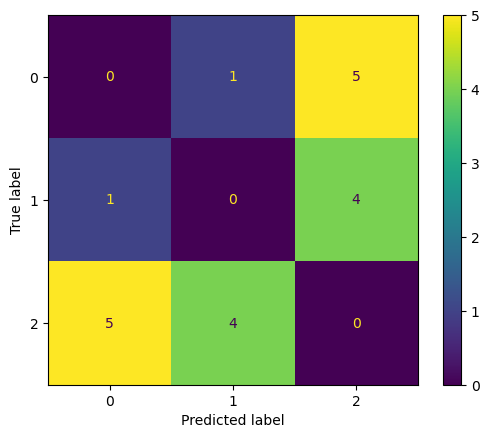

In [18]:
# plot confusion matrix on last batch
cm = confusion_matrix(labels.detach().cpu().numpy(), predicted.detach().cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


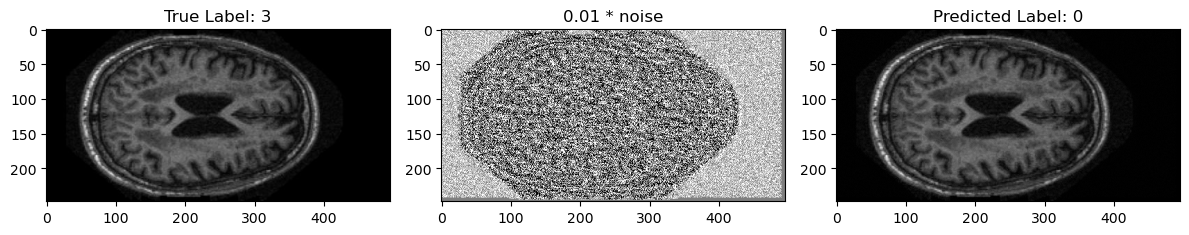

In [19]:
# lastly for visualization, we randomly select an image
indx = np.random.randint(0, len(labels), size = 1)

# Extract the original and perturbed images
original_image = images[indx].cpu().squeeze().detach().numpy()
perturbed_image = perturbed_images[indx].cpu().squeeze().detach().numpy()
# compute the noise:
noise = perturbed_image - original_image

# Get the true and predicted labels
true_label = labels[indx].item()
predicted_label = predicted[indx].item()

# Plot the images side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(original_image, cmap='gray')
axs[0].set_title(f"True Label: {true_label}")

axs[1].imshow(noise, cmap='gray')
axs[1].set_title(f"{epsilon} * noise")

axs[2].imshow(perturbed_image, cmap='gray')
axs[2].set_title(f"Predicted Label: {predicted_label}")

plt.tight_layout()
plt.show()
